# **Matrix Factorization Algorithm**

Matrix factorization is a collaborative filtering method used to predict missing entries in the user-item interaction matrix by decomposing it into two low-dimensional matrices:  Q (user embeddings) and P (item embeddings).

##### Initialize Matrices
- Randomly initialize  Q  and  P 
- Alternatively, use metadata embeddings to initialize these matrices.

---

##### Optimize for Loss Function
The goal is to minimize the squared error with regularization:

$$
L = \sum_{(i,j) \in R} \left( R_{ij} - Q_i \cdot P_j^\top \right)^2 + \lambda \left( \|Q_{i}\|^2 + \|P_{j}\|^2 \right)
$$

Where:
- R : The user-item interaction matrix.
- $R_{ij}$: Observed rating for user i and item j.
- $Q_i$ : Latent vector for user i.
- $P_j$ : Latent vector for item j.
- lambda : Regularization parameter to prevent overfitting.
- $|Q|^2$
---

##### Iterative Updates
- Update Q and P alternately to minimize the loss function L.
- Common optimization techniques include:
  
  
  - **Alternating Least Squares (ALS):**
  
    - Fix P and solve for Q, then fix Q and solve for P.
  
  - **Stochastic Gradient Descent (SGD):**
  
    - Update Q and P by iteratively taking gradient steps on L.

---

##### Output
- Q : Captures user preferences in a latent space.
- P : Captures item characteristics in the same latent space.

The predicted rating for user  i and item j is given by:

$$
\hat{R}_{ij} = Q_i \cdot P_j^\top
$$


In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [97]:

# Example of the 'ratings' DataFrame
# 
df_recommendation = pd.read_csv("data/base de donnée_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]

# Create user-item interaction matrix
user_ids = ratings['user'].unique()
item_ids = ratings['id'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings['user_idx'] = ratings['user'].map(user_id_map)
ratings['item_idx'] = ratings['id'].map(item_id_map)

# Train-Test Split using Leave-One-Out (for each user)
train_data, test_data = [], []

for user in ratings['user_idx'].unique():
    user_data = ratings[ratings['user_idx'] == user]
    if len(user_data) > 1:
        # Leave one out: use all but one interaction for training
        train_data.append(user_data.iloc[:-1])
        test_data.append(user_data.iloc[-1:])  # Last rating is used for testing

train_data = pd.concat(train_data, axis=0)
test_data = pd.concat(test_data, axis=0)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 37519
Testing data size: 4875


In [124]:
import pandas as pd

# Charger les données
df_recommendation = pd.read_csv("data/base de donnée_20_20.csv")
ratings = df_recommendation[['user', 'id', 'rating']]

# Création des mappings utilisateur-item
user_ids = ratings['user'].unique()
item_ids = ratings['id'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
item_id_map = {id: idx for idx, id in enumerate(item_ids)}

ratings['user_idx'] = ratings['user'].map(user_id_map)
ratings['item_idx'] = ratings['id'].map(item_id_map)

# Train-Test Split avec Leave-One-Out sur la dernière note > 4
train_data, test_data = [], []

for user in ratings['user_idx'].unique():
    user_data = ratings[ratings['user_idx'] == user]
    # Filtrer les notes > 4
    high_ratings = user_data[user_data['rating'] > 4]
    
    if len(high_ratings) > 0:
        # Sélectionner le dernier élément avec une note > 4 pour le test
        test_sample = high_ratings.iloc[-1]
        test_data.append(test_sample)
        
        # Utiliser les autres éléments pour l'entraînement
        train_samples = user_data[user_data.index != test_sample.name]
        train_data.append(train_samples)
    else:
        # Si aucun élément > 4, utiliser tous les éléments pour l'entraînement
        train_data.append(user_data)

# Combiner les données d'entraînement et de test
train_data = pd.concat(train_data, axis=0)
test_data = pd.DataFrame(test_data)

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 37711
Testing data size: 4915


##### Loss function $\mathbf{L}$ :

$$
L = \sum_{(i,j) \in R} \left( R_{ij} - Q_i \cdot P_j^\top \right)^2 + \lambda \left( \|Q_{i}\|^2 + \|P_{j}\|^2 \right)
$$

##### Dérivée par rapport à $\mathbf{p}_u$ :

$$

\frac{\partial L}{\partial \mathbf{p}_u} = -2 (r_{ui} - \mathbf{q}_i^\top \mathbf{p}_u) \mathbf{q}_i + 2\lambda \mathbf{p}_u
$$


##### Dérivée par rapport à $\mathbf{q}_i$ :

$$

\frac{\partial L}{\partial \mathbf{q}_i} = -2 (r_{ui} - \mathbf{q}_i^\top \mathbf{p}_u) \mathbf{p}_u + 2\lambda \mathbf{q}_i
$$


##### **1rst Training  with fixed regularization term on latent vectors** : 
##### Optimizer : Gradient descent algo

In [81]:
train_data.head(5)

,user,id,rating,user_idx,item_idx
0,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000EEHKVY,5.0,0,0
1,AE23JYHGEN3D35CHE5OQQYJOW5RA,B000TGSM6E,5.0,0,1
2,AE23JYHGEN3D35CHE5OQQYJOW5RA,B003WZ6VVM,3.0,0,2
3,AE23JYHGEN3D35CHE5OQQYJOW5RA,B008FDSWJ0,5.0,0,3
4,AE23JYHGEN3D35CHE5OQQYJOW5RA,B00EF8VGWE,5.0,0,4


In [125]:
test_data.head(5)

,user,id,rating,user_idx,item_idx
7,AE23JYHGEN3D35CHE5OQQYJOW5RA,B09YDBKT7M,5.0,0,7
24,AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BSR996X8,5.0,1,24
31,AE23WLBRYKEC67DM43M6E2MF7GPQ,B07TDNWYSB,5.0,2,31
60,AE23ZFVUOMPKR57BVSWXV34QLMVA,B0BTC9YJ2W,5.0,3,59
68,AE24I2EU3AJAAKBXF367XSV37U6Q,B0C994NVQK,5.0,4,67


### **Metrics definition ( RMSE, MAE, HR, NDCG) :**


In [ ]:
def prediction_rating ( user_id , item_id ,P , Q ,verbose = True) :
    user_idx = user_id_map[user_id] # nous permer d'avoir l'indice i 
    item_idx = item_id_map[item_id] # nous permet d'avoir l'indice j de la formule

    # If no convertion 
    # predicted_rating = np.dot(P[user_idx], Q[item_idx])
    
    # If integer between 1 and 5 convertion
    predicted_rating = np.dot(P[user_idx], Q[item_idx])
    predicted_rating = round(predicted_rating) 
    predicted_rating = max(1, min(5, predicted_rating))


    if verbose : 
        print(f"Predicted Rating for user-item pair: {predicted_rating:.2f}")

    return predicted_rating


####    **Evaluation with the leave one out (HR and NDCG) :**
#### General approach:

For each user in the test game, we have:

- The positive element (in id).

- The 99 negative elements (in negative_1, ..., negative_99).

The predictions for these 100 elements (1 positive + 99 negative) are calculated using the prediction_rating function.

We sort the elements according to the predicted scores. HR and NDCG are evaluated on the top-K elements.

In [111]:
def evaluate_model(test_data, P, Q, verbose = False):
    total_mae = 0
    total_rmse = 0
    num_test_samples = len(test_data)

    for _, row in test_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        prediction = np.dot(P[u], Q[i])
        total_mae += abs(r_ui - prediction)
        total_rmse += (r_ui - prediction) ** 2

    mae = total_mae / num_test_samples
    rmse = np.sqrt(total_rmse / num_test_samples)
    if verbose : 
        print(f"Evaluation Results:\nMAE: {mae:.4f}, RMSE: {rmse:.4f}")
    return mae, rmse

def generate_negative_items(test_data, all_items, num_negatives=99):
    """
    Générer des items négatifs pour chaque utilisateur.
    """
    negative_samples = []
    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item = row['id']
        # Exclure l'item positif des échantillons négatifs
        negative_items = np.random.choice(
            list(all_items - {positive_item}), 
            size=num_negatives, 
            # replace=False
        )
        negative_samples.append((user_id, positive_item, negative_items))
    return negative_samples

def evaluate_hr_ndcg(test_data, P, Q, user_id_map, item_id_map, K=10):
    """
    Évaluer HR@K et NDCG@K pour un test set donné.
    """
    all_items = set(item_id_map.keys())
    negative_samples = generate_negative_items(test_data, all_items)

    hr_list = []
    ndcg_list = []

    for user_id, positive_item, negative_items in negative_samples:
        user_idx = user_id_map[user_id]
        
        # Créer une liste contenant l'item positif et les négatifs
        candidate_items = [positive_item] + list(negative_items)
        candidate_indices = [item_id_map[item] for item in candidate_items]
        
        # Calculer les scores prédits pour tous les items candidats
        scores = [np.dot(P[user_idx], Q[item_idx]) for item_idx in candidate_indices]
        
        # Trier les items par score décroissant
        ranked_indices = np.argsort(scores)[::-1]  # Indices triés (scores décroissants)
        ranked_items = [candidate_items[i] for i in ranked_indices]
        
        # HR@K : Est-ce que l'item positif est dans le top K ?
        if positive_item in ranked_items[:K]:
            hr_list.append(1)
        else:
            hr_list.append(0)
        
        # NDCG@K : Position de l'item positif dans le classement
        if positive_item in ranked_items[:K]:
            position = ranked_items.index(positive_item)
            ndcg_list.append(1 / np.log2(position + 2))  # +2 car index commence à 0
        else:
            ndcg_list.append(0)

    # Moyennes sur tous les utilisateurs
    hr = np.mean(hr_list)
    ndcg = np.mean(ndcg_list)

    return hr, ndcg


### **Training :**

In [126]:

# Hyperparameters
num_factors = 10  # Latent space dimensionality
learning_rate = 0.01
reg_lambda = 0.1
num_epochs = 50

# Initialization of the latent factor matrices
num_users = len(user_ids)
num_items = len(item_ids)
P = np.random.normal(0, 0.1, (num_users, num_factors))  # User latent factors
Q = np.random.normal(0, 0.1, (num_items, num_factors))  # Item latent factors

# Training set
train_data = train_data[['user_idx', 'item_idx', 'rating']]
#train_data  = pd.read_csv('data\train20_10.csv')

# User and item frequency dictionaries for regularization
user_frequencies = train_data['user_idx'].value_counts().to_dict()
item_frequencies = train_data['item_idx'].value_counts().to_dict()

# To store the matrices P and Q at different epochs
stored_P = [P]
stored_Q = [Q]

loss_evolution = []
mae_evolution = []
rmse_evolution = []
hr_evolution = []
ndcg_evolution = []


# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for _, row in train_data.iterrows():
        u, i, r_ui = int(row['user_idx']), int(row['item_idx']), int(row['rating'])
        
        # Frequency-based regularization
        freq_user = user_frequencies[u]
        freq_item = item_frequencies[i]
        
        prediction = np.dot(P[u], Q[i])
        #error = r_ui - prediction 

        # Convert to class 
        predicted_rating = round(prediction) 
        predicted_rating = max(1, min(5, predicted_rating))
        error = r_ui - predicted_rating

        # Regularization terms for user and item
        reg_u = reg_lambda / np.sqrt(freq_user)  # Regularization for user
        reg_i = reg_lambda / np.sqrt(freq_item)  # Regularization for item

        # Update user and item latent factors by gradient descent
        P[u] += learning_rate * (error * Q[i] - reg_u * P[u])
        Q[i] += learning_rate * (error * P[u] - reg_i * Q[i])

        # Accumulate loss (including regularization)
        total_loss += error ** 2 + reg_lambda * (np.linalg.norm(P[u]) ** 2 + np.linalg.norm(Q[i]) ** 2)
    

    if (epoch + 1) % 5 == 0:
        stored_P.append(P.copy())
        stored_Q.append(Q.copy())

    loss_evolution.append(total_loss)
    # Evaluation of model on test set and  MAE & RMSE after each epoch
    mae, rmse = evaluate_model(train_data, P, Q)
    hr, ndcg = evaluate_hr_ndcg(test_data, P, Q, user_id_map, item_id_map, K=10)

    mae_evolution.append(mae)
    rmse_evolution.append(rmse)
    hr_evolution.append(hr)
    ndcg_evolution.append(ndcg)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f} -- MAE: {mae:.4f} -- RMSE: {rmse:.4f} -- HR: {hr:.4f} -- NDCG: {ndcg:.4f}")



Epoch 1/50, Loss: 486927.7877 -- MAE: 4.4363 -- RMSE: 4.5504 -- HR: 0.1233 -- NDCG: 0.0588
Epoch 2/50, Loss: 487227.3276 -- MAE: 4.4198 -- RMSE: 4.5335 -- HR: 0.1530 -- NDCG: 0.0850
Epoch 3/50, Loss: 488558.4674 -- MAE: 4.3422 -- RMSE: 4.4597 -- HR: 0.2006 -- NDCG: 0.1276
Epoch 4/50, Loss: 484704.8333 -- MAE: 4.0044 -- RMSE: 4.1790 -- HR: 0.2722 -- NDCG: 0.1719
Epoch 5/50, Loss: 449069.9687 -- MAE: 3.2882 -- RMSE: 3.5748 -- HR: 0.2970 -- NDCG: 0.1807
Epoch 6/50, Loss: 357276.2331 -- MAE: 2.4432 -- RMSE: 2.8211 -- HR: 0.2802 -- NDCG: 0.1587
Epoch 7/50, Loss: 245716.7275 -- MAE: 1.7648 -- RMSE: 2.1474 -- HR: 0.2437 -- NDCG: 0.1203
Epoch 8/50, Loss: 165099.0360 -- MAE: 1.3038 -- RMSE: 1.6464 -- HR: 0.1921 -- NDCG: 0.0884
Epoch 9/50, Loss: 121962.1626 -- MAE: 1.0209 -- RMSE: 1.3190 -- HR: 0.1487 -- NDCG: 0.0672
Epoch 10/50, Loss: 101183.3851 -- MAE: 0.8512 -- RMSE: 1.1149 -- HR: 0.1192 -- NDCG: 0.0565
Epoch 11/50, Loss: 90386.5594 -- MAE: 0.7509 -- RMSE: 0.9907 -- HR: 0.1154 -- NDCG: 0.054

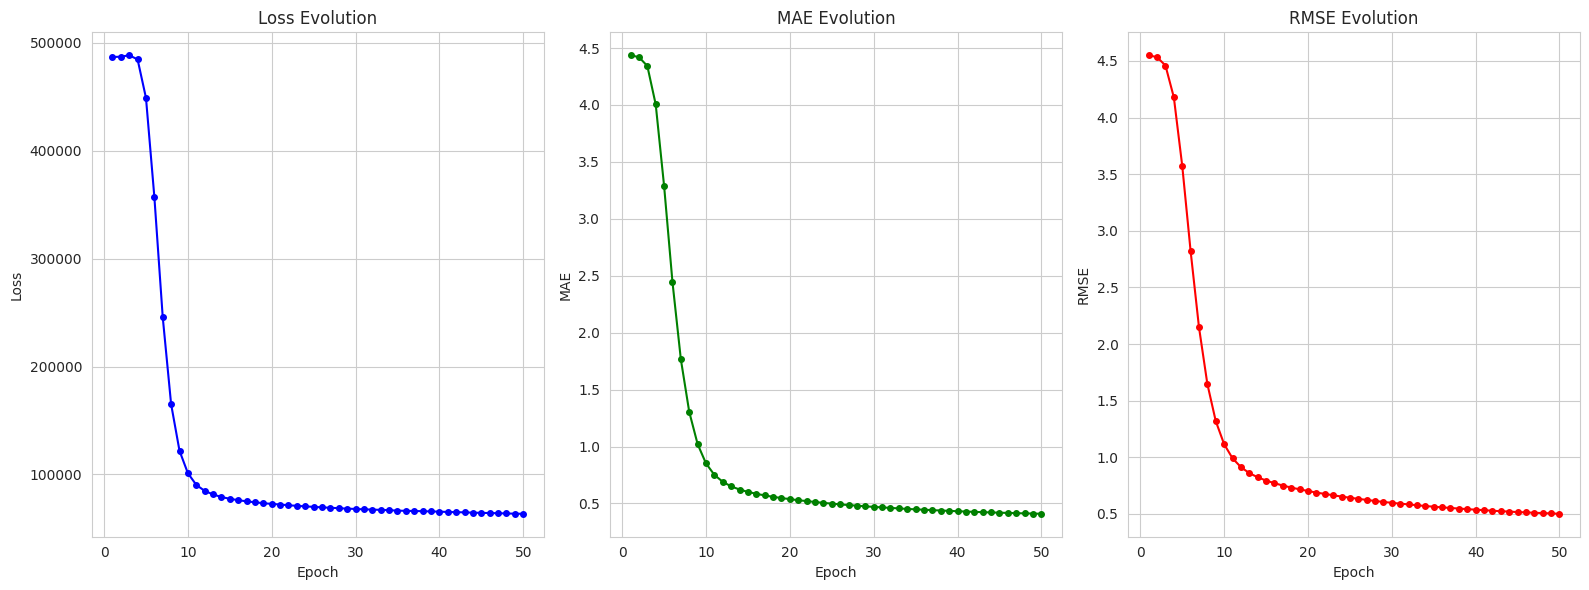

In [129]:
# Plotting Loss, MAE, and RMSE over epochs
plt.figure(figsize=(16, 6))

# Plotting Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), loss_evolution, marker='o', color='b', label="Loss",markersize=4)
plt.title('Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plotting MAE
plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), mae_evolution, marker='o', color='g', label="MAE",markersize=4)
plt.title('MAE Evolution')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

# Plotting RMSE
plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs + 1), rmse_evolution, marker='o', color='r', label="RMSE",markersize=4)
plt.title('RMSE Evolution')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.grid(True)


plt.tight_layout()
plt.show()

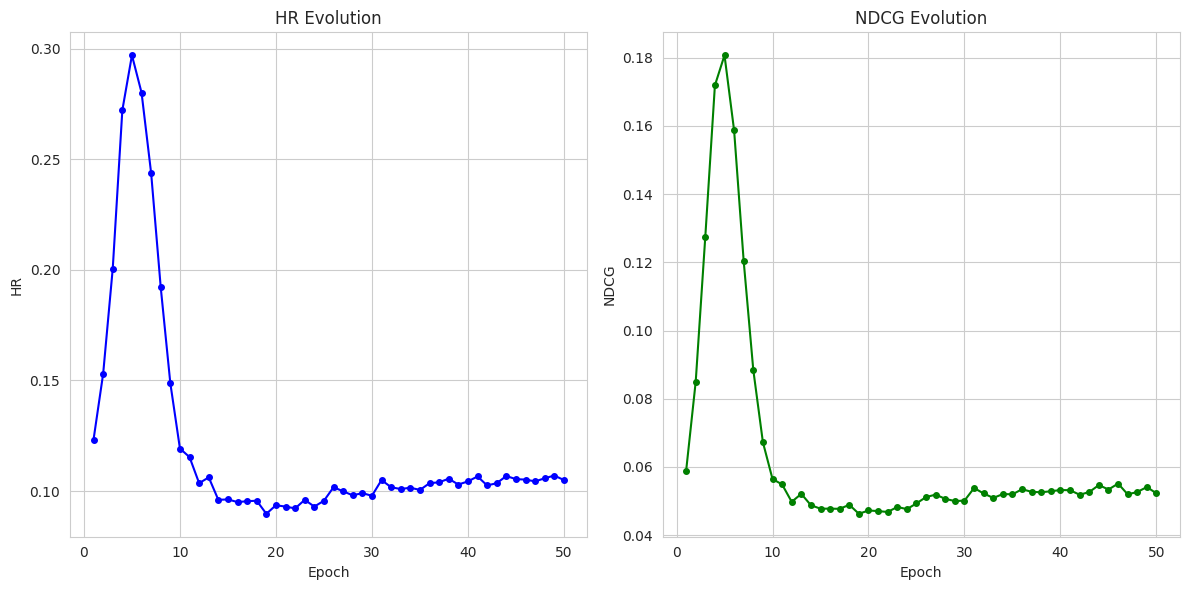

In [130]:
# Plotting HR , NDCG over epochs
plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), hr_evolution, marker='o', color='b', label="Loss",markersize=4)
plt.title('HR Evolution')
plt.xlabel('Epoch')
plt.ylabel('HR')
plt.grid(True)

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), ndcg_evolution, marker='o', color='g', label="MAE",markersize=4)
plt.title('NDCG Evolution')
plt.xlabel('Epoch')
plt.ylabel('NDCG')
plt.grid(True)


plt.tight_layout()
plt.show()

### **Evaluation : (test set) RMSE and MAE**

In [128]:
# After training the model, evaluation using test_data
mae_evaluate, rmse_evaluate = evaluate_model(test_data, P, Q, verbose = True)

Evaluation Results:
MAE: 1.3393, RMSE: 1.7217


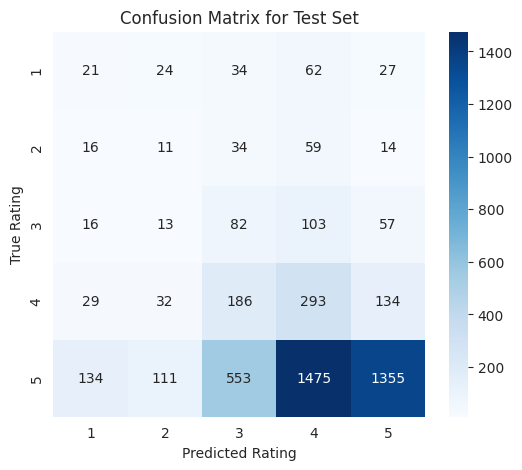

In [117]:

# Prédictions sur l'ensemble de test
y_true = []  
y_pred = []  

for _, row in test_data.iterrows():
    user_id = row['user']
    item_id = row['id']
    true_rating = row['rating']
    
    pred_rating = prediction_rating(user_id, item_id, P, Q, verbose = False)
    
    y_true.append(true_rating)
    y_pred.append(pred_rating)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion Matrix for Test Set")
plt.xlabel("Predicted Rating")
plt.ylabel("True Rating")
plt.show()


### **Prediction  distibution :** 

In [137]:
test_data

,user,id,rating,user_idx,item_idx
7,AE23JYHGEN3D35CHE5OQQYJOW5RA,B09YDBKT7M,5.0,0,7
24,AE23LDQTB7L76AP6E6WPBFVYL5DA,B0BSR996X8,5.0,1,24
31,AE23WLBRYKEC67DM43M6E2MF7GPQ,B07TDNWYSB,5.0,2,31
60,AE23ZFVUOMPKR57BVSWXV34QLMVA,B0BTC9YJ2W,5.0,3,59
68,AE24I2EU3AJAAKBXF367XSV37U6Q,B0C994NVQK,5.0,4,67
...,...,...,...,...,...
42576,AHZPLXCE5YQMLXFFBSURYHZUGMTA,B0BLLXXT6F,5.0,5102,397
42597,AHZQPH7HHSWLUIQFWEQ54NNKKN6A,B0BT9R8MMV,5.0,5103,32
42601,AHZT6MVWNF4GG6FISMZMORKZKK4A,B0BQ4HSKC9,5.0,5104,885
42609,AHZXMBKQJTVG2J7P7EB5WCYTOLDQ,B0C67HCGBR,5.0,5105,210


In [142]:

# Example 1 : 
user_id = "AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ"
item_id = "B0B8F6LD9F"

pred = prediction_rating( user_id , item_id, P, Q )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 4.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
42624,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B0B8F6LD9F,5.0,5106,20


In [132]:
# Example 2 : 
user_id = "AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ"
item_id = "B095XZJ99J"
pred = prediction_rating( user_id , item_id, P, Q )
print("The true rating is  : ")
ratings.query(f'user == "{user_id}" and id == "{item_id}"')

Predicted Rating for user-item pair: 5.00
The true rating is  : 


,user,id,rating,user_idx,item_idx
42621,AHZYZ2BUDD7WAJPW5G6K2DK5LYPQ,B095XZJ99J,5.0,5106,403


<Axes: ylabel='Count'>

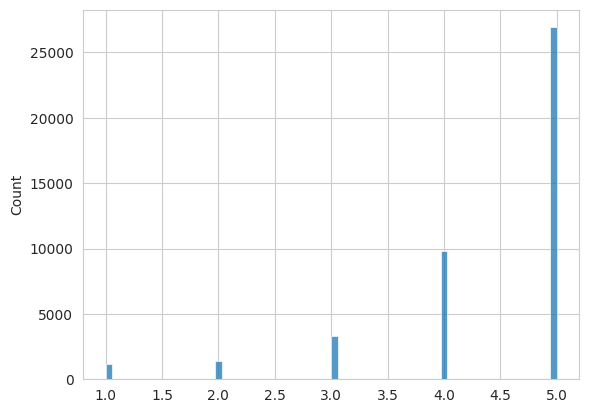

In [46]:

ratings_list = []
for _, row in ratings.iterrows() : 
    user_id = row['user']
    item_id =  row['id']
    pred = prediction_rating( user_id , item_id , verbose = False)
    ratings_list.append(pred)
    
import seaborn as sns
sns.set_style('whitegrid')
sns.histplot(ratings_list)

In [121]:
from ipywidgets import interact

def plot_histogram(epoch):
    ratings_list = []
    
    # Calcul des prédictions pour l'époque sélectionnée
    P_epoch = stored_P[epoch]
    Q_epoch = stored_Q[epoch]

    for _, row in ratings.iterrows():
        user_id = row['user']
        item_id = row['id']
        pred = prediction_rating(user_id, item_id, P_epoch, Q_epoch, verbose = False)
        ratings_list.append(pred)

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_list, bins=5, kde=False, color="blue")
    plt.title(f"Distribution of Predicted Ratings at Epoch {(epoch )*5}")
    plt.xlabel("Predicted Rating")
    plt.ylabel("Frequency")
    plt.show()

# Créer un curseur interactif pour changer l'époque et afficher l'histogramme
interact(plot_histogram, epoch=(0, (num_epochs // 5)+ 1- 1))

interactive(children=(IntSlider(value=5, description='epoch', max=10), Output()), _dom_classes=('widget-intera…

<function __main__.plot_histogram(epoch)>

## **Annexe :**

In [94]:

# Simulation : 
num_users = test_data['user_idx'].max() + 1
num_items = test_data['item_idx'].max() + 1
P = np.random.rand(num_users, 10)  # Dimension utilisateur
Q = np.random.rand(num_items, 10)  # Dimension article

user_id_map = {user: idx for idx, user in enumerate(test_data['user'])}
item_id_map = {item: idx for idx, item in enumerate(test_data['id'])}

# Calcule HR@10 et NDCG@10
hr, ndcg = evaluate_hr_ndcg(test_data, P, Q, user_id_map, item_id_map, K=10)

print(f"HR@10: {hr:.4f}, NDCG@10: {ndcg:.4f}")


HR@10: 0.1061, NDCG@10: 0.0499


In [ ]:
########################################################
########## POUR METHODE AVEC LE FICHIER NEGTIVE DIRECT / 

test_negative = pd.read_csv("data/test_negative20_10.csv")



def hit_ratio_and_ndcg(test_data, P, Q, K=10):
    """
    Évalue le modèle sur Hit Ratio (HR) et NDCG.

    Args:
        test_data (DataFrame): Jeu de données test avec colonnes `user`, `id`, `negative_1`, ..., `negative_99`.
        P (ndarray): Matrice des utilisateurs.
        Q (ndarray): Matrice des items.
        K (int): Nombre d'éléments dans le top-K.

    Returns:
        float, float: Moyenne de HR et NDCG sur tous les utilisateurs.
    """
    hits, ndcgs = [], []

    for _, row in test_data.iterrows():
        user_id = row['user']
        positive_item = row['id']
        negative_items = row[4:].values  # Les colonnes `negative_1` à `negative_99`.

        # Construire la liste des items (1 positif + 99 négatifs)
        items = [positive_item] + list(negative_items)
        
        # Calculer les prédictions pour ces items
        print(f"{items}") ['B09YDBKT7M', 7]
        scores = [prediction_rating(user_id, item_id, P, Q, verbose=False) for item_id in items]

        # Trier les items selon les scores prédits (ordre décroissant)
        ranked_items = np.argsort(scores)[::-1]  # Indices triés par ordre décroissant

        # HR et NDCG pour cet utilisateur
        if 0 in ranked_items[:K]:  # L'élément positif est au rang 0 dans `items`
            hits.append(1)
            rank = np.where(ranked_items == 0)[0][0] + 1  # Rang réel du positif
            ndcgs.append(1 / np.log2(rank + 1))
        else:
            hits.append(0)
            ndcgs.append(0)

    # Moyenne des métriques
    mean_hr = np.mean(hits)
    mean_ndcg = np.mean(ndcgs)

    return mean_hr, mean_ndcg